In [1]:
#Imports
import sys
sys.path.append('../../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

from datetime import datetime
import time as t

In [2]:
starttime = t.time()

data = dp.getXYdata_wXYerr('../data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (list(a) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1 = np.asarray(v_err1)
#Express as weights
weighdata = 1/v_err1

In [3]:
#keeping others but holding them constant, All Parameters
def f(r,M,h,pref):
     return np.sqrt(nf.bh_v(r,M,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + nf.b_v(r,load=True,path='../')**2 
                    + nf.d_v(r,h,pref,load=True,path='../')**2)
    
#keeping others but holding them constant, No h
def g(r,M,pref):
     return np.sqrt(nf.bh_v(r,M,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + nf.b_v(r,load=True,path='../')**2 
                    + nf.d_v(r,pref,load=True,path='../')**2)
    
#Only Black Hole and Disk, All Parameters
def bh_d(r,M,h,pref):
    return np.sqrt(nf.bh_v(r,M,load=True,path='../')**2 + nf.d_v(r,h,pref,load=True,path='../')**2)

#Only Black Hole and Disk, No h
def bh_d2(r,M,pref):
    return np.sqrt(nf.bh_v(r,M,load=True,path='../')**2 + nf.d_v(r,pref,load=True,path='../')**2)

In [4]:
#Fit, Keeping rest constant, All Parameters

#Setup
l_mod = lm.Model(f)
l_params = l_mod.make_params()
#Black Hole
l_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Disk
l_params.add('h', value=nf.h_c, min=0, max=1000)
l_params.add('pref', value=nf.pref_def, min=0)
#Do fit
l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

In [5]:
#Fit, Keeping rest constant, No h

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Black Hole
g_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Disk
g_params.add('pref', value=nf.pref_def, min=0)
#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [6]:
#Fit, BH and D only, All Parameters

#Setup
bhd_mod = lm.Model(bh_d)
bhd_params = bhd_mod.make_params()
#Black Hole
bhd_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Disk
bhd_params.add('h', value=nf.h_c, min=0, max=1000)
bhd_params.add('pref', value=nf.pref_def, min=0)
#Do fit
bhd_fit = bhd_mod.fit(v_dat,bhd_params,r=r_dat,weights=weighdata)

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


In [7]:
#Fit, BH and D only, No h

#Setup
bhd2_mod = lm.Model(bh_d2)
bhd2_params = bhd2_mod.make_params()
#Black Hole
bhd2_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Disk
bhd2_params.add('pref', value=nf.pref_def, min=0)
#Do fit
bhd2_fit = bhd2_mod.fit(v_dat,bhd2_params,r=r_dat,weights=weighdata)

In [8]:
#Define curves to plot

l_dict = l_fit.best_values
l_M = l_dict['M']
l_h = l_dict['h']
l_pref = l_dict['pref']
l_curve = f(r_dat,l_M,l_h,l_pref)

g_dict = g_fit.best_values
g_M = g_dict['M']
g_pref = g_dict['pref']
g_curve = g(r_dat,g_M,g_pref)

bhd_dict = bhd_fit.best_values
bhd_M = bhd_dict['M']
bhd_h = bhd_dict['h']
bhd_pref = bhd_dict['pref']

bhd2_dict = bhd_fit.best_values
bhd2_M = bhd_dict['M']
bhd2_pref = bhd_dict['pref']

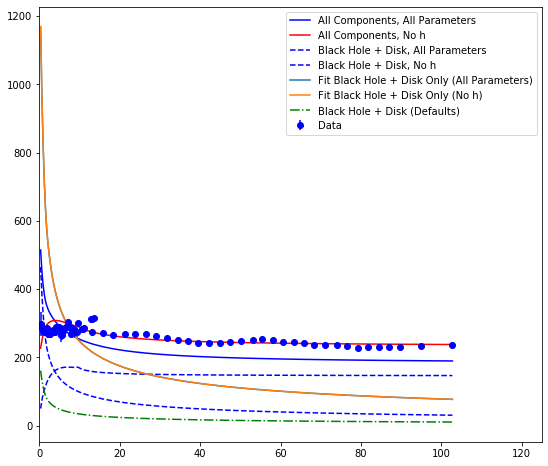

In [16]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,125)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='All Components, All Parameters')
plt.plot(r_dat,g_curve,'r-',label='All Components, No h')
plt.plot(r_dat,bh_d(r_dat,l_M,l_h,l_pref),'b--',label='Black Hole + Disk, All Parameters')
plt.plot(r_dat,bh_d2(r_dat,g_M,g_pref),'b--',label='Black Hole + Disk, No h')
plt.plot(r_dat,bh_d(r_dat,bhd_M,bhd_h,bhd_pref),label='Fit Black Hole + Disk Only (All Parameters)')
plt.plot(r_dat,bh_d2(r_dat,bhd2_M,bhd2_pref),label='Fit Black Hole + Disk Only (No h)')
plt.plot(r_dat,bh_d(r_dat,nf.Mbh_def,nf.h_c,nf.pref_def),'g-.',label='Black Hole + Disk (Defaults)')

plt.legend()
plt.show()

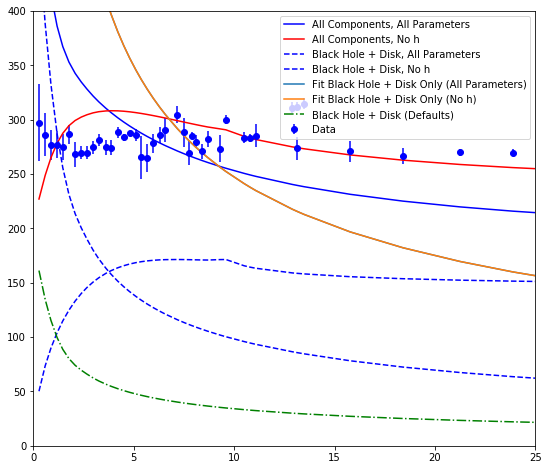

In [17]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)
plt.ylim(0,400)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='All Components, All Parameters')
plt.plot(r_dat,g_curve,'r-',label='All Components, No h')
plt.plot(r_dat,bh_d(r_dat,l_M,l_h,l_pref),'b--',label='Black Hole + Disk, All Parameters')
plt.plot(r_dat,bh_d2(r_dat,g_M,g_pref),'b--',label='Black Hole + Disk, No h')
plt.plot(r_dat,bh_d(r_dat,bhd_M,bhd_h,bhd_pref),label='Fit Black Hole + Disk Only (All Parameters)')
plt.plot(r_dat,bh_d2(r_dat,bhd2_M,bhd2_pref),label='Fit Black Hole + Disk Only (No h)')
plt.plot(r_dat,bh_d(r_dat,nf.Mbh_def,nf.h_c,nf.pref_def),'g-.',label='Black Hole + Disk (Defaults)')

plt.legend()
plt.show()

In [18]:
print('Fit information for all-component fit (All Parameters):')
l_fit

Fit information for all-component fit (All Parameters):


In [19]:
print('Fit information for all-component fit (No h):')
g_fit

Fit information for all-component fit (No h):


In [20]:
print('Fit information for two-component fit (All Parameters):')
bhd_fit

Fit information for two-component fit (All Parameters):


In [21]:
print('Fit information for two-component fit (No h):')
bhd2_fit

Fit information for two-component fit (No h):


In [15]:
endtime = t.time()
print('Total Time:')
print(str(endtime - starttime)+' seconds')
print('')

print('Timestamp:')
print(datetime.now())

Total Time:
37002.57969903946 seconds

Timestamp:
2019-10-14 01:00:37.912549
